In [1]:
import pickle
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, RobustScaler
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as pl
from matplotlib import rcParams
from seaborn import PairGrid, heatmap, kdeplot
import cmocean.cm as cmo

In [2]:
% matplotlib inline
rcParams['axes.titlesize'] = 18
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['font.size'] = 16

In [3]:
df_pca = pd.read_pickle('./pickleJar/df_4_pca3_frombwnorm.pkl')
df_chl = pd.read_pickle('./pickleJar/df_4_AllFeatures_n_Longhurst.pkl')

In [4]:
df_chl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 494 entries, 0 to 494
Data columns (total 23 columns):
datetime         494 non-null datetime64[ns]
lat              494 non-null float64
lon              494 non-null float64
Biome            494 non-null object
BiomCat          494 non-null int64
Province         494 non-null object
ProvCode         494 non-null object
Coastal          494 non-null int64
ProvCat          494 non-null int64
oisst            494 non-null float64
etopo2           494 non-null float64
solz             494 non-null float64
sat_rho_rc412    494 non-null float64
sat_rho_rc443    494 non-null float64
sat_rho_rc490    494 non-null float64
sat_rho_rc510    494 non-null float64
sat_rho_rc555    494 non-null float64
sat_rho_rc670    494 non-null float64
chl_fluo         363 non-null float64
chl_hplc         158 non-null float64
chl              423 non-null float64
log10_chl        423 non-null float64
is_hplc          494 non-null bool
dtypes: bool(1), datetime6

In [5]:
def make_features_from_dt(df, cleanup=True):
    yeardays = max(df.datetime.dt.dayofyear.max(), 365)
    dayminutes = 24 * 60
    doy_arg = 2 * np.pi * df.datetime.dt.dayofyear / yeardays
    mod_arg = 2 * np.pi * (df.datetime.dt.hour * 60 + df.datetime.dt.minute) / dayminutes
    df['sin_doy'] = np.sin(doy_arg)
    df['cos_doy'] = np.cos(doy_arg)
    df['sin_minofday'] = np.sin(mod_arg)
    df['cos_minofday'] = np.cos(mod_arg)
    if cleanup:
        df.drop('datetime', axis=1, inplace=True)
    
    
def make_features_from_latlon(df, cleanup=True):
    df['x'] = np.cos(np.deg2rad(df.lat)) * np.cos(np.deg2rad(df.lon))
    df['y'] = np.cos(np.deg2rad(df.lat)) * np.sin(np.deg2rad(df.lon))
    df['z'] = np.sin(np.deg2rad(df.lat))
    if cleanup:
        df.drop(['lat', 'lon'], axis=1, inplace=True)

def log_transform_feature(df, feature, cleanup=True):
    df['log10_' + feature] = np.log10(df[feature]+1e-6)
    if cleanup:
        df.drop(feature, axis=1, inplace=True)

In [6]:
def PlotPairwise(dfr, beg_feat):
    _, ax = pl.subplots(figsize=(18, 16))
    ax.set_facecolor('k')
    d = dfr.loc[:, beg_feat:].corr().iloc[1:, :-1]
    heatmap(d, vmin=-1, vmax=1, annot=True, cmap=cmo.balance_r,
            mask=np.triu(np.ones([d.shape[1]]*2), k=1), fmt='.1g', linewidth=1,
            linecolor='k');

In [7]:
satcols = df_chl.filter(regex='sat').columns
df_chl.drop(satcols, axis=1, inplace=True)

In [8]:
log_transform_feature(df_chl, 'etopo2')

In [9]:
make_features_from_dt(df_chl)

In [10]:
make_features_from_latlon(df_chl)

In [11]:
df_chl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 494 entries, 0 to 494
Data columns (total 21 columns):
Biome           494 non-null object
BiomCat         494 non-null int64
Province        494 non-null object
ProvCode        494 non-null object
Coastal         494 non-null int64
ProvCat         494 non-null int64
oisst           494 non-null float64
solz            494 non-null float64
chl_fluo        363 non-null float64
chl_hplc        158 non-null float64
chl             423 non-null float64
log10_chl       423 non-null float64
is_hplc         494 non-null bool
log10_etopo2    494 non-null float64
sin_doy         494 non-null float64
cos_doy         494 non-null float64
sin_minofday    494 non-null float64
cos_minofday    494 non-null float64
x               494 non-null float64
y               494 non-null float64
z               494 non-null float64
dtypes: bool(1), float64(14), int64(3), object(3)
memory usage: 81.5+ KB


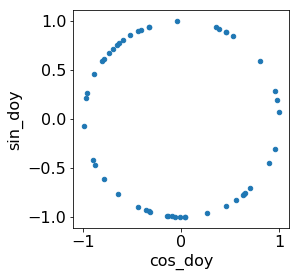

In [12]:
ax = df_chl.sample(50).plot(kind='scatter', x='cos_doy', y='sin_doy')
ax.set_aspect(1)

In [13]:
df_chl.describe().T

,count,mean,std,min,25%,50%,75%,max
BiomCat,494.0,1.536437,1.375565,0.000000,0.000000,2.000000,3.000000,3.000000
Coastal,494.0,0.417004,0.493563,0.000000,0.000000,0.000000,1.000000,1.000000
ProvCat,494.0,28.882591,16.174203,2.000000,17.000000,29.000000,46.000000,50.000000
oisst,494.0,19.044089,6.973292,0.780000,13.772500,19.600000,25.027500,30.510000
solz,494.0,31.314170,14.531983,0.000000,20.700000,32.300000,42.650000,69.900000
chl_fluo,363.0,1.416348,3.219245,0.025000,0.206000,0.516100,1.237450,43.100000
chl_hplc,158.0,2.324667,4.019108,0.027000,0.221500,0.815785,2.170500,23.984000
chl,423.0,1.635382,3.527198,0.025000,0.198850,0.535410,1.381735,43.100000
log10_chl,423.0,-0.240235,0.605531,-1.602060,-0.701477,-0.271314,0.140423,1.634477
log10_etopo2,494.0,2.041634,1.164348,-6.000000,1.306327,2.193125,2.715585,3.742647


In [14]:
cols =['Biome', 'BiomCat', 'Province', 'ProvCode', 'Coastal', 'ProvCat',
       'sin_doy', 'cos_doy', 'sin_minofday', 'cos_minofday', 'x', 'y', 'z',
       'log10_etopo2', 'oisst', 'solz' ]
df_features = df_chl[cols]

In [15]:
df_features.loc[172:176].T

,172,173,175,176
Biome,Westerlies,Westerlies,Westerlies,Westerlies
BiomCat,3,3,3,3
Province,N. Pacific Subtropical Gyre Province (West),N. Pacific Subtropical Gyre Province (West),N. Pacific Subtropical Gyre Province (West),N. Pacific Subtropical Gyre Province (West)
ProvCode,NPSW,NPSW,NPSW,NPSW
Coastal,0,0,0,0
ProvCat,47,47,47,47
sin_doy,-0.835925,-0.835925,-0.845249,-0.845249
cos_doy,-0.548843,-0.548843,-0.534373,-0.534373
sin_minofday,-0.980785,-0.92388,-0.707107,-0.932008
cos_minofday,0.19509,0.382683,-0.707107,-0.362438


In [16]:
df_pca.dropna().loc[172:176]

,PC1,PC2,PC3,PC4,PC5,PC6
172,0.042179,-0.028720,-0.000202,0.003095,0.000890,2.003778e-17
173,0.038200,-0.030585,-0.000523,0.003317,0.000786,3.591620e-17
175,0.038593,-0.030481,-0.001518,0.001891,0.001331,-3.761385e-18
176,0.027936,-0.027678,-0.003713,0.002157,0.001255,3.873667e-17


In [17]:
df_features = pd.merge(df_features, df_pca.dropna(), 
                       how='outer', left_index=True, right_index=True)

In [18]:
df_features.loc[172:176].T

,172,173,175,176
Biome,Westerlies,Westerlies,Westerlies,Westerlies
BiomCat,3,3,3,3
Province,N. Pacific Subtropical Gyre Province (West),N. Pacific Subtropical Gyre Province (West),N. Pacific Subtropical Gyre Province (West),N. Pacific Subtropical Gyre Province (West)
ProvCode,NPSW,NPSW,NPSW,NPSW
Coastal,0,0,0,0
ProvCat,47,47,47,47
sin_doy,-0.835925,-0.835925,-0.845249,-0.845249
cos_doy,-0.548843,-0.548843,-0.534373,-0.534373
sin_minofday,-0.980785,-0.92388,-0.707107,-0.932008
cos_minofday,0.19509,0.382683,-0.707107,-0.362438


In [19]:
df_ = pd.concat((df_features, df_chl[['log10_chl']]), axis=1)

In [20]:
df_.head().T

,0,1,2,3,4
Biome,Westerlies,Polar,Polar,Polar,Trades
BiomCat,3,1,1,1,2
Province,"Mediterranean Sea, Black Sea Province",Antarctic Province,Austral Polar Province,Austral Polar Province,N. Atlantic Tropical Gyral Province (Trpg)
ProvCode,MEDI,ANTA,APLR,APLR,NATR
Coastal,0,0,0,0,0
ProvCat,42,22,25,25,33
sin_doy,-0.984474,0.790946,0.758306,0.369725,-0.997917
cos_doy,0.175531,0.611886,0.651899,0.929141,-0.0645084
sin_minofday,0.601815,-0.965926,-0.887011,-0.442289,0.134851
cos_minofday,-0.798636,-0.258819,-0.461749,-0.896873,-0.990866


In [21]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 494 entries, 0 to 494
Data columns (total 23 columns):
Biome           494 non-null object
BiomCat         494 non-null int64
Province        494 non-null object
ProvCode        494 non-null object
Coastal         494 non-null int64
ProvCat         494 non-null int64
sin_doy         494 non-null float64
cos_doy         494 non-null float64
sin_minofday    494 non-null float64
cos_minofday    494 non-null float64
x               494 non-null float64
y               494 non-null float64
z               494 non-null float64
log10_etopo2    494 non-null float64
oisst           494 non-null float64
solz            494 non-null float64
PC1             494 non-null float64
PC2             494 non-null float64
PC3             494 non-null float64
PC4             494 non-null float64
PC5             494 non-null float64
PC6             494 non-null float64
log10_chl       423 non-null float64
dtypes: float64(17), int64(3), object(3)
memory usage

In [22]:
df_.to_pickle('./pickleJar/df_5_AllFeatures_w_Longhurst_n_pca.pkl')

#### Data Standardization

This must happen before computing interactions; i.e. it is not appropriate to standardize interactions. See more [here](http://quantpsy.org/interact/interactions.htm).

In [27]:
x_scaler = StandardScaler()
x_pca_scaler = StandardScaler()

In [23]:
x_rscaler = RobustScaler()
x_pca_rscaler = RobustScaler()

In [39]:
df_.loc[:, 'log10_etopo2':'PC6'].head().T

,0,1,2,3,4
log10_etopo2,2.664642e+00,3.550106e+00,2.518514e+00,3.341039e+00,3.640382e+00
oisst,1.957000e+01,2.540000e+00,7.800000e-01,1.790000e+00,2.467000e+01
solz,4.870000e+01,5.120000e+01,5.270000e+01,4.590000e+01,2.800000e+01
PC1,2.599015e-02,6.059977e-02,6.401805e-02,7.017476e-02,1.057401e-01
PC2,-2.472721e-02,-2.012915e-02,2.166605e-02,1.318215e-02,-8.207225e-04
PC3,-9.138836e-03,-9.907661e-03,5.765024e-03,7.062456e-04,6.903413e-03
PC4,7.740306e-04,-2.622886e-03,7.145722e-03,3.174944e-03,8.477726e-05
PC5,-2.796834e-03,-3.462634e-03,1.576635e-03,-5.347301e-04,-9.711815e-04
PC6,1.464986e-17,1.192921e-17,5.577568e-17,3.729566e-17,-6.272597e-17


In [24]:
dX = df_.loc[:, 'log10_etopo2':'PC6']
dXpca = df_.filter(regex='PC')

In [28]:
dX_s = pd.DataFrame(x_scaler.fit_transform(dX.values), index=df_.index,
                    columns=['%s_s' %col for col in dX.columns])
dX_s = pd.merge(df_.loc[:, 'sin_doy': 'z'], dX_s, how='outer', right_index=True,
                left_index=True)
dXpca_s = pd.DataFrame(x_pca_scaler.fit_transform(dXpca.values), index=df_.index,
                       columns=['%s_s' % col for col in dXpca.columns])

In [30]:
dX_rs = pd.DataFrame(x_rscaler.fit_transform(dX.values), index=df_.index,
                    columns=['%s_s' %col for col in dX.columns])
dX_rs = pd.merge(df_.loc[:, 'sin_doy': 'z'], dX_rs, how='outer', right_index=True,
                left_index=True)
dXpca_rs = pd.DataFrame(x_pca_rscaler.fit_transform(dXpca.values), index=df_.index,
                       columns=['%s_s' % col for col in dXpca.columns])

#### Make Interactions

In [53]:
dX_s.head().T

,0,1,2,3,4
sin_doy,-0.984474,0.790946,0.758306,0.369725,-0.997917
cos_doy,0.175531,0.611886,0.651899,0.929141,-0.064508
sin_minofday,0.601815,-0.965926,-0.887011,-0.442289,0.134851
cos_minofday,-0.798636,-0.258819,-0.461749,-0.896873,-0.990866
x,0.700808,0.222167,0.266604,0.267607,0.851946
y,0.328432,-0.423148,-0.399605,-0.404279,-0.327023
z,0.633246,-0.878400,-0.877062,-0.874611,0.408955
log10_etopo2_s,0.535612,1.296863,0.409983,1.117124,1.374476
oisst_s,0.075494,-2.369156,-2.621804,-2.476819,0.807598
solz_s,1.197597,1.369805,1.473131,1.004723,-0.228292


In [52]:
polymaker = PolynomialFeatures(interaction_only=True, include_bias=False)
Xpoly = polymaker.fit_transform(dX_s.values)
xpoly_col_names = polymaker.get_feature_names(dX_s.columns)
dXpoly = pd.DataFrame(Xpoly, index=df_.index, columns=xpoly_col_names)

In [33]:
rpolymaker = PolynomialFeatures(interaction_only=True, include_bias=False)
Xrpoly = rpolymaker.fit_transform(dX_rs.values)
xrpoly_col_names = rpolymaker.get_feature_names(dX_rs.columns)
dXrpoly = pd.DataFrame(Xrpoly, index=df_.index, columns=xrpoly_col_names)

In [43]:
pcapolymaker = PolynomialFeatures(interaction_only=True, include_bias=False)
XpolyPca = pcapolymaker.fit_transform(dXpca_s.values)
xpolypca_col_names = pcapolymaker.get_feature_names(dXpca_s.columns)
dXpolyPca = pd.DataFrame(XpolyPca, index=df_.index, columns=xpolypca_col_names)

In [34]:
pcarpolymaker = PolynomialFeatures(interaction_only=True, include_bias=False)
XrpolyPca = pcarpolymaker.fit_transform(dXpca_rs.values)
xrpolypca_col_names = pcarpolymaker.get_feature_names(dXpca_rs.columns)
dXrpolyPca = pd.DataFrame(XrpolyPca, index=df_.index, columns=xrpolypca_col_names)

#### Data Organization

In [54]:
ds = pd.concat((df_.loc[:, 'Biome':'ProvCat'], dX_s, df_.log10_chl),
               join='outer', axis=1)

In [35]:
drs = pd.concat((df_.loc[:, 'Biome':'ProvCat'], dX_rs, df_.log10_chl),
               join='outer', axis=1)

In [36]:
dprs = pd.concat((df_.loc[:, 'Biome':'ProvCat'], dXrpoly, df_.log10_chl),
                join='outer', axis=1)

In [60]:
dX_s.head().T

,0,1,2,3,4
sin_doy,-0.984474,0.790946,0.758306,0.369725,-0.997917
cos_doy,0.175531,0.611886,0.651899,0.929141,-0.064508
sin_minofday,0.601815,-0.965926,-0.887011,-0.442289,0.134851
cos_minofday,-0.798636,-0.258819,-0.461749,-0.896873,-0.990866
x,0.700808,0.222167,0.266604,0.267607,0.851946
y,0.328432,-0.423148,-0.399605,-0.404279,-0.327023
z,0.633246,-0.878400,-0.877062,-0.874611,0.408955
log10_etopo2_s,0.535612,1.296863,0.409983,1.117124,1.374476
oisst_s,0.075494,-2.369156,-2.621804,-2.476819,0.807598
solz_s,1.197597,1.369805,1.473131,1.004723,-0.228292


In [61]:
dX_s.head().T

,0,1,2,3,4
sin_doy,-0.984474,0.790946,0.758306,0.369725,-0.997917
cos_doy,0.175531,0.611886,0.651899,0.929141,-0.064508
sin_minofday,0.601815,-0.965926,-0.887011,-0.442289,0.134851
cos_minofday,-0.798636,-0.258819,-0.461749,-0.896873,-0.990866
x,0.700808,0.222167,0.266604,0.267607,0.851946
y,0.328432,-0.423148,-0.399605,-0.404279,-0.327023
z,0.633246,-0.878400,-0.877062,-0.874611,0.408955
log10_etopo2_s,0.535612,1.296863,0.409983,1.117124,1.374476
oisst_s,0.075494,-2.369156,-2.621804,-2.476819,0.807598
solz_s,1.197597,1.369805,1.473131,1.004723,-0.228292


In [37]:
dppcar = pd.concat((df_.loc[:, 'Biome':'ProvCat'], dX_rs.loc[:, 'sin_doy':'solz_s'],
                   dXrpolyPca, df_.log10_chl), join='outer',axis=1)

In [68]:
ds.loc[172:175].T

,172,173,175
Biome,Westerlies,Westerlies,Westerlies
BiomCat,3,3,3
Province,N. Pacific Subtropical Gyre Province (West),N. Pacific Subtropical Gyre Province (West),N. Pacific Subtropical Gyre Province (West)
ProvCode,NPSW,NPSW,NPSW
Coastal,0,0,0
ProvCat,47,47,47
sin_doy,-0.835925,-0.835925,-0.845249
cos_doy,-0.548843,-0.548843,-0.534373
sin_minofday,-0.980785,-0.92388,-0.707107
cos_minofday,0.19509,0.382683,-0.707107


In [64]:
dps.loc[172:175].T

,172,173,175
Biome,Westerlies,Westerlies,Westerlies
BiomCat,3,3,3
Province,N. Pacific Subtropical Gyre Province (West),N. Pacific Subtropical Gyre Province (West),N. Pacific Subtropical Gyre Province (West)
ProvCode,NPSW,NPSW,NPSW
Coastal,0,0,0
ProvCat,47,47,47
sin_doy,-0.835925,-0.835925,-0.845249
cos_doy,-0.548843,-0.548843,-0.534373
sin_minofday,-0.980785,-0.92388,-0.707107
cos_minofday,0.19509,0.382683,-0.707107


In [65]:
dppca.loc[171:176].T

,171,172,173,175,176
Biome,Westerlies,Westerlies,Westerlies,Westerlies,Westerlies
BiomCat,3,3,3,3,3
Province,N. Pacific Subtropical Gyre Province (West),N. Pacific Subtropical Gyre Province (West),N. Pacific Subtropical Gyre Province (West),N. Pacific Subtropical Gyre Province (West),N. Pacific Subtropical Gyre Province (West)
ProvCode,NPSW,NPSW,NPSW,NPSW,NPSW
Coastal,0,0,0,0,0
ProvCat,47,47,47,47,47
sin_doy,-0.835925,-0.835925,-0.835925,-0.845249,-0.845249
cos_doy,-0.548843,-0.548843,-0.548843,-0.534373,-0.534373
sin_minofday,-0.999762,-0.980785,-0.92388,-0.707107,-0.932008
cos_minofday,0.0218149,0.19509,0.382683,-0.707107,-0.362438


In [73]:
ds.to_pickle('./pickleJar/df_6_FullSet_noInteractions.pkl')
dps.to_pickle('./pickleJar/df_6_FullSet_MaxInteractions.pkl')
dppca.to_pickle('./pickleJar/df_6_FullSet_PCAInteractions.pkl')

In [38]:
drs.to_pickle('./pickleJar/df_rs_6_FullSet_noInteractions.pkl')
dprs.to_pickle('./pickleJar/df_rs_6_FullSet_MaxInteractions.pkl')
dppcar.to_pickle('./pickleJar/df_rs_6_FullSet_PCAInteractions.pkl')

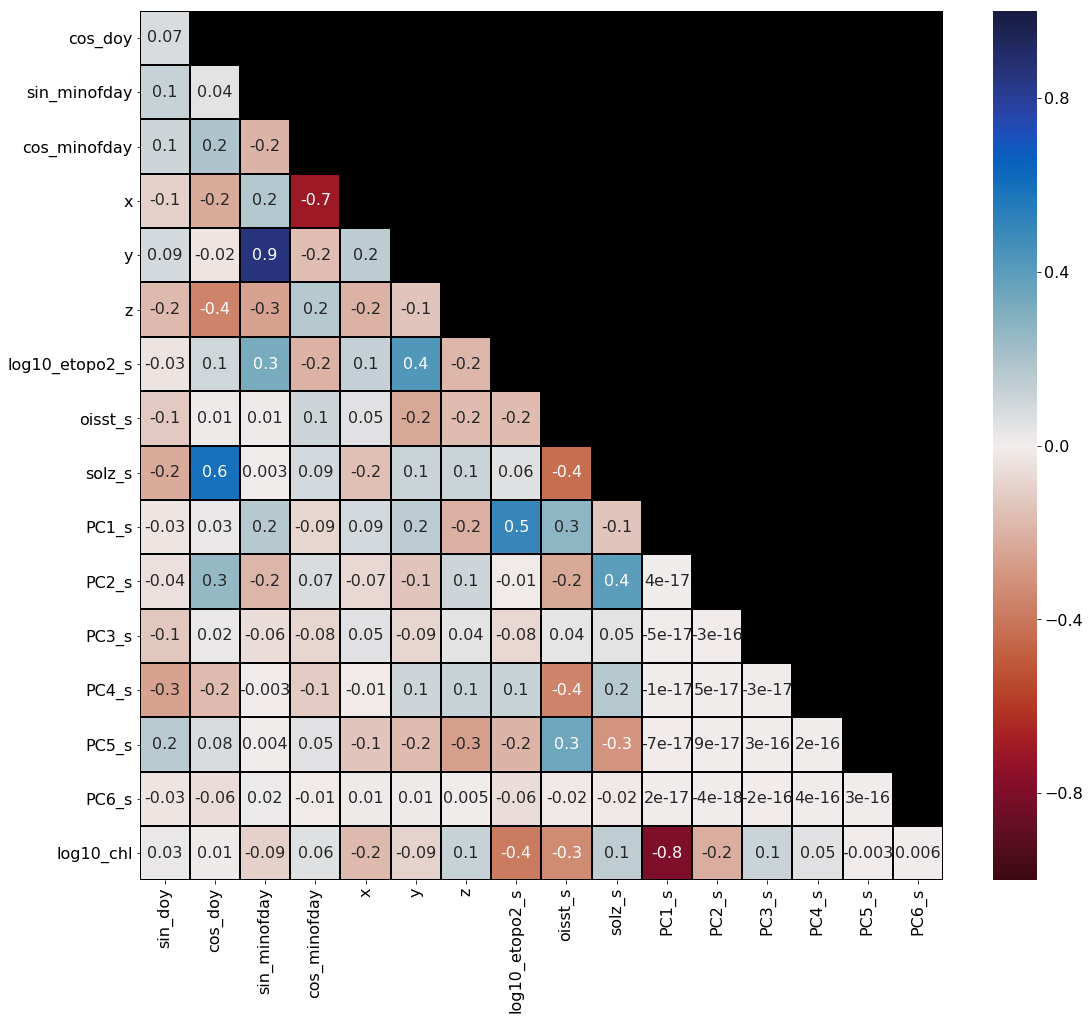

In [71]:
PlotPairwise(ds, beg_feat='sin_doy')

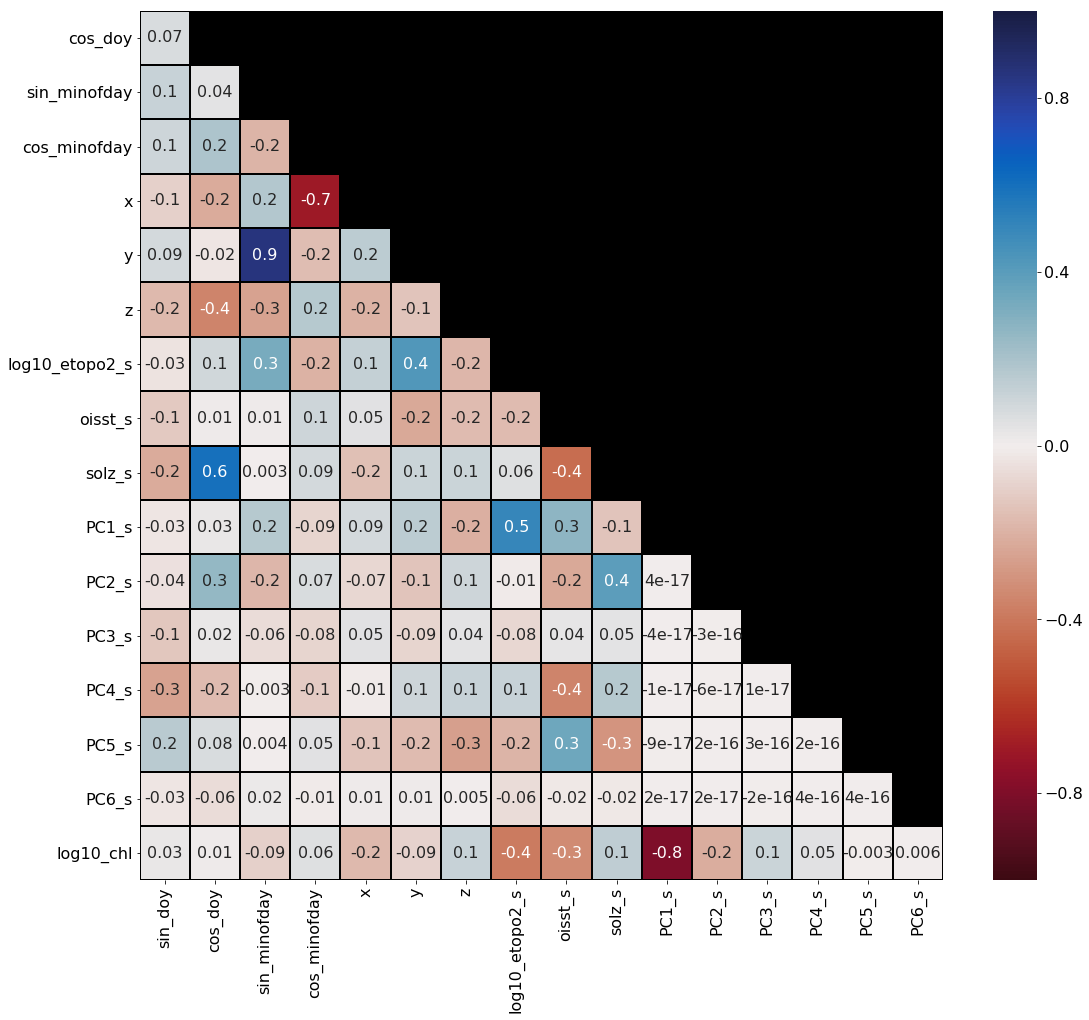

In [39]:
PlotPairwise(drs, beg_feat='sin_doy')

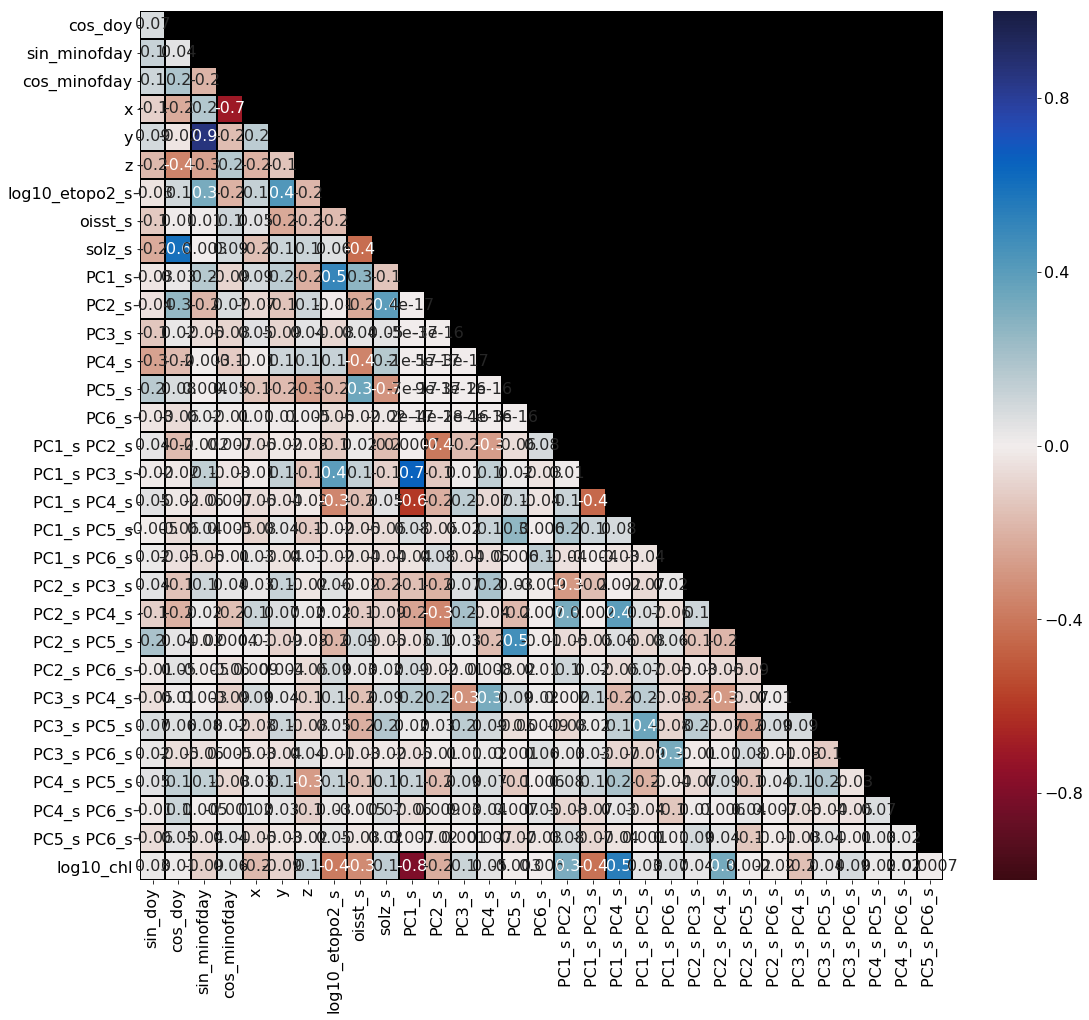

In [72]:
PlotPairwise(dppca, beg_feat='sin_doy')